# Implement of "Single Image Haze Removal Using Dark Channel Prior"

## compute dark channel
$$
J^{dark}(x)=min_{c\in{\{r,g,b\}}}(min_{y\in{\Omega (x)}}(J^c(y)))
$$

In [211]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


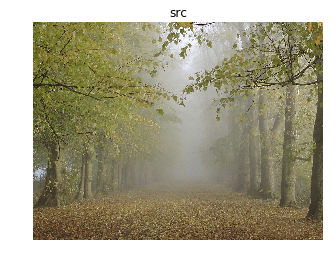

In [212]:
src=cv2.imread('haze_img/9.jpg')
plt.title('src')
plt.axis('off')
plt.imshow(src[:,:,::-1])

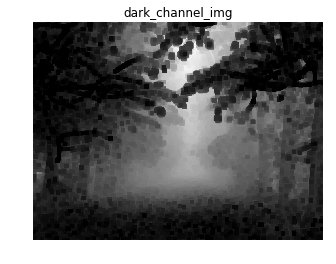

In [213]:
def compute_dark_channel(img,patch_size=15):
    h,w=img.shape[:2]
    b, g, r = cv2.split(img)
    bgr_min_img = cv2.min(cv2.min(b, g), r)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size,patch_size))
    dark_channel_img = cv2.erode(bgr_min_img, kernel)
    return dark_channel_img

dark_channel_img=compute_dark_channel(src,patch_size=15)
plt.title('dark_channel_img')
plt.axis('off')
plt.imshow(dark_channel_img,cmap='gray')

## compute atmosphere
We first pick the top 0.1% brightest pixels in the dark channel. Among these pixels, the pixels with highest intensity in the input image I is selected as the atmospheric light

In [214]:
def compute_atmosphere_light(img,dark_channel_img):
    h,w=dark_channel_img.shape[:2]
    num_of_candiate=int(0.001*h*w)
    dark_channel=dark_channel_img.reshape(-1,1)[:,0]
    arg_sorted=np.argsort(dark_channel)[::-1]
    img=img.astype(np.float32)
    atmosphere_light=np.zeros((3,))
    for i in range(num_of_candiate):
        index=arg_sorted[i]
        row_index=index//w
        col_index=index%w
        for c in range(3):
            atmosphere_light[c]=max(atmosphere_light[c],img[row_index,col_index][c])
    return atmosphere_light

atmosphere_light=compute_atmosphere_light(src,dark_channel_img)
print(atmosphere_light)

[255. 252. 249.]


## Estimate the Transmission and Soft Matting
$$
t(x)=1-\omega min_c(min_{y\in\Omega(x)} \frac{I^c(y)}{A^c})
$$

In [215]:
def guied_filter(I,P,radius,epsilon):
    window_size=2*radius+1
    meanI=cv2.blur(I,(window_size,window_size))
    meanP=cv2.blur(P,(window_size,window_size))
    II=I**2
    IP=I*P
    corrI=cv2.blur(II,(window_size,window_size))
    corrIP=cv2.blur(IP,(window_size,window_size))
    varI=corrI-meanI**2
    covIP=corrIP-meanI*meanP
    a=covIP/(varI+epsilon)
    b=meanP-a*meanI
    meanA=cv2.blur(a,(window_size,window_size))
    meanB=cv2.blur(b,(window_size,window_size))
    transmission_rate=meanA*I+meanB
    return transmission_rate

In [216]:
def compute_transmission_rate(img,atmosphere_light_max,dark_channel_img,omega=0.95,guided_filter_radius=50,epsilon=0.0001):
    h,w=img.shape[:2]
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    zero_mat=np.zeros((h,w))
    transmition_rate_est=cv2.max(zero_mat,np.ones_like(zero_mat)-omega*dark_channel_img/atmosphere_light_max)
    #transmission_rate = guied_filter(img_gray,transmition_rate_est, guided_filter_radius, epsilon)
    transmission_rate=cv2.ximgproc.guidedFilter(img_gray.astype(np.float32),transmition_rate_est.astype(np.float32),guided_filter_radius,epsilon)
    return transmission_rate

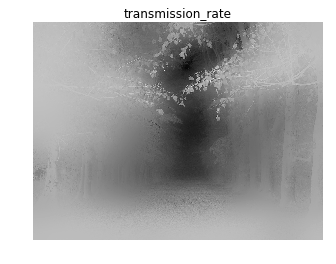

In [217]:
transmission_rate=compute_transmission_rate(src,np.max(atmosphere_light),dark_channel_img)
plt.title('transmission_rate')
plt.axis('off')
plt.imshow(transmission_rate,cmap='gray')

## Recovering the Scene Radiance
$$
J(x)=\frac{I(x)-A}{max(t(x),t_0)}+A
$$

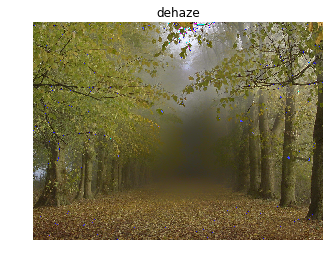

In [218]:
min_transmission=0.1
transmission_rate[transmission_rate<min_transmission]=min_transmission
dehaze_img=np.zeros_like(src,dtype=np.uint8)
for c in range(3):
    dehaze_img[:,:,c]=(src[:,:,c]-atmosphere_light[c])/transmission_rate+atmosphere_light[c]
dehaze_img[dehaze_img>255]=255
dehaze_img[dehaze_img<0]=0
plt.title('dehaze')
plt.axis('off')
plt.imshow(dehaze_img[:,:,::-1])


## Reference
[1] He K, Sun J, Tang X. Single image haze removal using dark channel prior[C]// Computer Vision and Pattern Recognition, 2009. CVPR 2009. IEEE Conference on. IEEE, 2009:1956-1963.  
[2] He K, Sun J, Tang X. Guided Image Filtering[M]// Computer Vision – ECCV 2010. Springer Berlin Heidelberg, 2010:1397-1409.